## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [1]:
import matplotlib.pyplot as plt
import activity_classifier_utils
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor

In [2]:
import glob

import numpy as np
import scipy as sp
import scipy.io


def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]

def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estim0tes = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)

def RunPulseRateAlgorithm(data_fl, ref_fl ,high_pass = 40/ 60,low_pass = 240/60,fs = 125):
    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    
    # loading the reference file
    ground_truth = sp.io.loadmat(ref_fl)['BPM0']
    
    # bandpass filtering the signals
    accx = BandpassFilter(accx, (high_pass,low_pass), fs=fs)
    accy = BandpassFilter(accy, (high_pass,low_pass), fs=fs)
    accz = BandpassFilter(accz, (high_pass,low_pass), fs=fs)

    acc = acc_mag(accx,accy,accz) # calculatnig the magnitude of the accelerometers
    
    ppg =  BandpassFilter(ppg, (high_pass,low_pass), fs=fs)
    
    confidence, estimates = get_estimates(ppg, acc, fs)
    
    estimates = estimates*60
    
    
    # Compute pulse rate estimates and estimation confidence.
    print(ground_truth.shape, estimates.shape, ppg.shape)
    print(data_fl)
    print(ref_fl)
    errors = mean_absolute_error(ground_truth, estimates)
    
    # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.

    return errors, confidence

In [14]:
# HYPERPARAMETER

high_pass = 40/ 60 # changing BPM to Hz
low_pass = 240/60 # changing BPM to Hz

fs = 125



In [401]:
Evaluate()

(148, 1) (148,) (37937,)
./datasets/troika/training_data/DATA_01_TYPE01.mat
./datasets/troika/training_data/REF_01_TYPE01.mat
(148, 1) (148,) (37850,)
./datasets/troika/training_data/DATA_02_TYPE02.mat
./datasets/troika/training_data/REF_02_TYPE02.mat
(140, 1) (140,) (35989,)
./datasets/troika/training_data/DATA_03_TYPE02.mat
./datasets/troika/training_data/REF_03_TYPE02.mat
(107, 1) (107,) (27576,)
./datasets/troika/training_data/DATA_04_TYPE01.mat
./datasets/troika/training_data/REF_04_TYPE01.mat
(146, 1) (144,) (37250,)
./datasets/troika/training_data/DATA_04_TYPE02.mat
./datasets/troika/training_data/REF_04_TYPE02.mat


ValueError: Found input variables with inconsistent numbers of samples: [146, 144]

In [15]:
((37250/fs)-8)/2

145.0

In [16]:
def acc_mag(accx,accy,accz):
    """
    calculates the magnitude of the the accelerometers 
    
    """
    return np.sqrt(accx**2 + (accy - np.mean(accy))**2 + accz**2)

def BandpassFilter(signal, band_pass = (40/60, 240/60), fs = fs):
    
    """
    performs a bandpass filter on the provided data.
    """
    
    b,a = scipy.signal.butter(3, band_pass, fs=fs, btype= 'bandpass')
    return scipy.signal.filtfilt(b,a,signal)

def getpeaks(signal,fs, height = None, width = None ):
    
    """
    performs fourier transfom then finds the peaks in the frequency domain.
    
    returns the peaks values, corresponding frequencies and the fourier trasform
    """

    freqs= np.fft.rfftfreq(2*len(signal), 1/fs)

    fourier= np.abs(np.fft.rfft(signal, 2*len(signal)))

    pks = sp.signal.find_peaks(fourier, height = height, distance = width)[0]
    
    piks = []
    herzs = []

    for pik in pks:
        piks.append(fourier[pik])
    piks = sorted(piks)
    
    for pik in piks:
        herzs.append(freqs[np.where(fourier == pik)[0][0]])
        
    piks = piks[::-1]
    herzs = herzs[::-1]

    return piks, herzs, fourier


def get_estimates(ppg, acc, fs, ppg_height = 2000, ppg_width = 10, acc_height = 150, acc_width = None):
    
    """
    calcultates the heart rate estimation and confidence
    """
    
    pred_bpm = []
    conf = []

    
    
    for i in range( int(((ppg.shape[0]/fs)-8)/2)+1 ):

        ppg_window = ppg[i*2*fs:(8*fs+i*2*fs)]
        acc_window = acc[i*2*fs:(8*fs+i*2*fs)]
        ppg_pks,ppg_herz, ppg_f = getpks(ppg_window, fs,height= ppg_height, width= ppg_width)
        P,acc_herz, F = getpks(acc_window, fs,height= acc_height, width= acc_width)


        for i in range(len(ppg_herz)):
            if ppg_herz[i] not in acc_herz:
                pred_bpm.append(ppg_herz[i])
                conf.append(ppg_pks[i]/ppg_f)
                break

    conf = np.array(conf)
    pred_bpm = np.array(pred_bpm)
    
    return conf, pred_bpm

In [17]:
import scipy.signal

1 - Filter the signal 40-240 BPM

In [18]:
from sklearn.metrics import mean_absolute_error

In [20]:
# data = "./datasets/troika/training_data/DATA_04_TYPE02.mat"
# ref = "./datasets/troika/training_data/REF_04_TYPE02.mat"
data_fls, ref_fls = LoadTroikaDataset()
ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])
ground_truth = sp.io.loadmat(ref_fls[0])['BPM0']

In [21]:
accx = BandpassFilter(accx, (high_pass,low_pass), fs=fs)
accy = BandpassFilter(accy, (high_pass,low_pass), fs=fs)
accz = BandpassFilter(accz, (high_pass,low_pass), fs=fs)

acc = np.sqrt(accx**2 + (accy - np.mean(accy))**2 + accz**2)

ppg =  BandpassFilter(ppg, (high_pass,low_pass), fs=fs)


In [22]:
int((((ppg.shape[0]/fs)-8)/2)+1)

148

In [25]:
pred_bpm = []
conf = []
acc_bpm = []

for i in range( int(((ppg.shape[0]/fs)-8)/2)+1 ):
# for i in range(2):
#     print(i*2,8+i*2)
    ppg_window = ppg[i*2*fs:(8*fs+i*2*fs)]
    acc_window = acc[i*2*fs:(8*fs+i*2*fs)]
    ppg_pks,ppg_herz, ppg_f = getpeaks(ppg_window, fs,height= 2000, width=10)
    P,acc_herz, F = getpeaks(acc_window, fs,height= 150, width=None)
    
#     print(len(ppg_herz), ppg_herz[0])
#     print(len(acc_herz), acc_herz[0])
#     print(ppg_herz[0] in acc_herz)

#     pred_bpm.append(ppg_herz[0])
#     acc_bpm.append(acc_herz[0])
    
#     if ppg_herz[0] not in acc_herz:
#         print('First', ppg_herz[0])
#         pred_bpm.append(ppg_herz[0])
        
#     elif ppg_herz[1] not in acc_herz:
#         print("Second", ppg_herz[1])
#         pred_bpm.append(ppg_herz[1])
# #         break
#     elif ppg_herz[2] not in acc_herz:
#         print("Third", ppg_herz[0],ppg_herz[1], ppg_herz[2])
#         print(acc_herz)
#         pred_bpm.append(ppg_herz[2])
# #         break
        
#     else:
#         print('Joker', ppg_herz[0])
#         pred_bpm.append(ppg_herz[0])
    print("ppg len is",len(ppg_herz))
    print(i)
    for j in range(len(ppg_herz)):
        if ppg_herz[j] not in acc_herz:
            pred_bpm.append(ppg_herz[j])
            conf.append(ppg_pks[j]/ppg_f)
#             print(j)
            break
        
        elif ppg_herz[j] in acc_herz:
            print('yo')
        
conf = np.array(conf)
pred_bpm = np.array(pred_bpm)

ppg len is 2
0
ppg len is 2
1
ppg len is 2
2
ppg len is 3
3
ppg len is 2
4
ppg len is 2
5
ppg len is 2
6
ppg len is 3
7
ppg len is 2
8
ppg len is 2
9
ppg len is 2
10
ppg len is 3
11
ppg len is 1
12
ppg len is 2
13
ppg len is 3
14
ppg len is 4
15
ppg len is 5
16
ppg len is 3
17
ppg len is 4
18
ppg len is 5
19
ppg len is 5
20
ppg len is 4
21
ppg len is 6
22
ppg len is 4
23
ppg len is 7
24
ppg len is 6
25
ppg len is 7
26
ppg len is 6
27
ppg len is 6
28
ppg len is 6
29
ppg len is 7
30
ppg len is 6
31
ppg len is 6
32
ppg len is 6
33
ppg len is 7
34
ppg len is 7
35
ppg len is 6
36
ppg len is 7
37
ppg len is 6
38
ppg len is 6
39
ppg len is 7
40
ppg len is 6
41
ppg len is 4
42
ppg len is 6
43
ppg len is 7
44
ppg len is 8
45
ppg len is 5
46
ppg len is 5
47
ppg len is 6
48
ppg len is 7
49
ppg len is 7
50
ppg len is 6
51
ppg len is 5
52
ppg len is 7
53
ppg len is 7
54
ppg len is 6
55
ppg len is 8
56
ppg len is 7
57
ppg len is 8
58
ppg len is 7
59
ppg len is 8
60
ppg len is 9
61
ppg len is 5
62
pp

In [26]:
pred_bpm.shape

(148,)

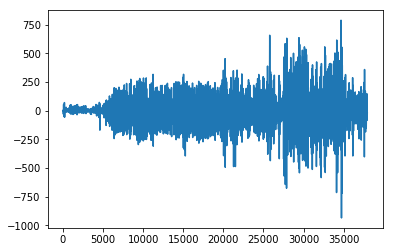

In [27]:
plt.plot(ppg)

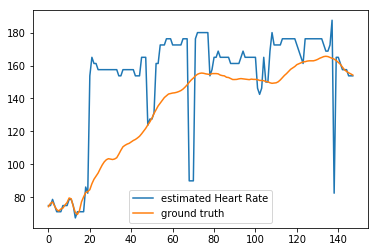

In [28]:

plt.plot(pred_bpm*60, label = 'estimated Heart Rate')
# plt.plot(pred_bpm1*60)
# plt.plot(acc_bpm)
plt.plot(ground_truth, label = 'ground truth')
plt.legend()

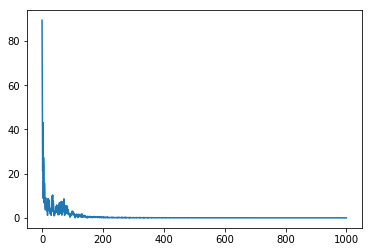

In [33]:
plt.plot(F)

# What is below this cell is Just for understanding and working through some parts.

In [34]:
ppg[i*2*fs:(8*fs+i*2*fs)]

array([ -1.57803187e+02,  -1.53241565e+02,  -1.47076059e+02,
        -1.39405013e+02,  -1.30342170e+02,  -1.20016052e+02,
        -1.08569399e+02,  -9.61586138e+01,  -8.29531099e+01,
        -6.91344941e+01,  -5.48954778e+01,  -4.04384240e+01,
        -2.59734272e+01,  -1.17158449e+01,   2.11677532e+00,
         1.53083877e+01,   2.76487172e+01,   3.89380013e+01,
         4.89920375e+01,   5.76473197e+01,   6.47660057e+01,
         7.02404400e+01,   7.39969613e+01,   7.59987447e+01,
         7.62474779e+01,   7.47837261e+01,   7.16859171e+01,
         6.70679469e+01,   6.10754869e+01,   5.38811492e+01,
         4.56787281e+01,   3.66767902e+01,   2.70919178e+01,
         1.71419275e+01,   7.03938387e+00,  -3.01429940e+00,
        -1.28339144e+01,  -2.22544604e+01,  -3.11339402e+01,
        -3.93548681e+01,  -4.68244782e+01,  -5.34736915e+01,
        -5.92549667e+01,  -6.41392180e+01,  -6.81120356e+01,
        -7.11694876e+01,  -7.33138018e+01,  -7.45492414e+01,
        -7.48784727e+01,

In [31]:
result = getpks(ppg,fs)

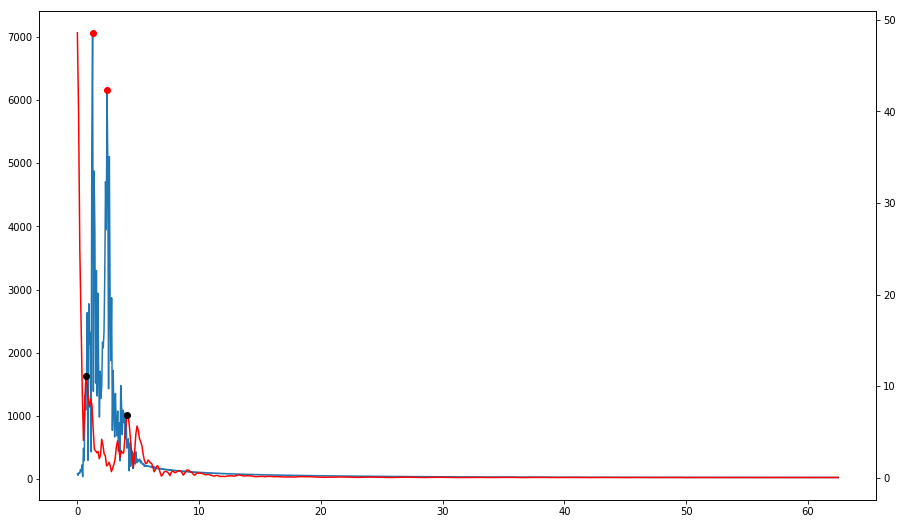

In [166]:
signal = ppg[0:8*fs]
freqs= np.fft.rfftfreq(2*len(signal), 1/fs)
fourier= np.abs(np.fft.rfft(signal, 2*len(signal)))
pks = sp.signal.find_peaks(fourier,height=2000, distance=10)[0]

piks = []
herzs = []

for pik in pks:
    piks.append(fourier[pik])

piks = sorted(piks)
for pik in piks:
    herzs.append(freqs[np.where(fourier == pik)[0][0]])

piks = piks[::-1]

herzs = herzs[::-1]


plt.figure(figsize = (15,9))
plt.plot(freqs,fourier)
plt.plot(freqs[pks], fourier[pks], 'or')
# print(freqs[pks])
plt.twinx()
plt.plot(acc_freqs,acc_fourier, 'r')
plt.plot(acc_freqs[acc_pks], acc_fourier[acc_pks], 'ok')

In [173]:
print(acc_herz)
print(herzs)

[0.70000000000000007, 4.1000000000000005]
[1.25, 2.4375]


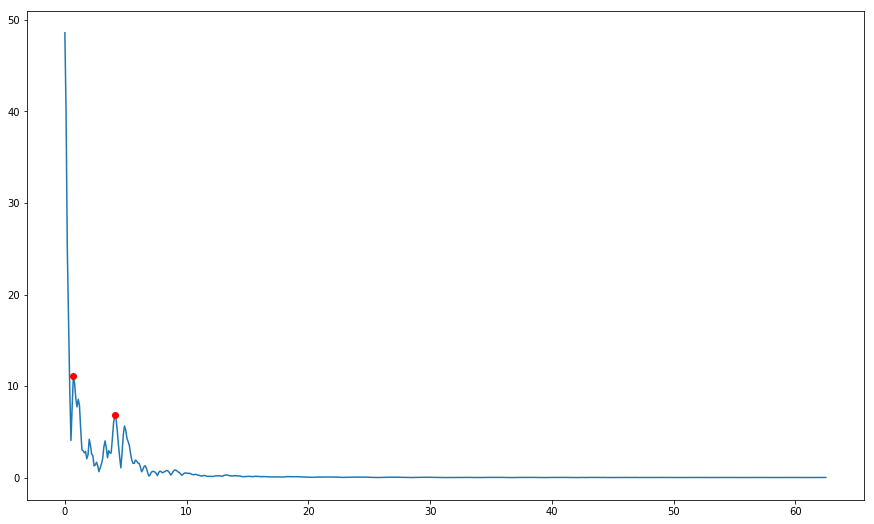

In [160]:
signal = acc[0:5*fs]
freqs= np.fft.rfftfreq(2*len(signal), 1/fs)
fourier= np.abs(np.fft.rfft(signal, 2*len(signal)))
pks = sp.signal.find_peaks(fourier, height= 5, distance=10)[0]

piks = []
herzs = []

for pik in pks:
    piks.append(fourier[pik])

piks = sorted(piks)
for pik in piks:
    herzs.append(freqs[np.where(fourier == pik)[0][0]])

piks = piks[::-1]

herzs = herzs[::-1]


plt.figure(figsize = (15,9))
plt.plot(freqs,fourier)
plt.plot(freqs[pks], fourier[pks], 'or')
# print(freqs[pks])

acc_freqs = freqs
acc_fourier = fourier
acc_pks = pks
acc_herz = herzs
acc_piks = piks

In [162]:
acc_herz

[0.70000000000000007, 4.1000000000000005]

In [144]:
def get_prediction(accx = accx, accy = accy, accz = accz, ppg = ppg):
    
    accx = BandpassFilter(accx, (high_pass,low_pass), fs=fs)
    accy = BandpassFilter(accy, (high_pass,low_pass), fs=fs)
    accz = BandpassFilter(accz, (high_pass,low_pass), fs=fs)

    acc = acc_mag(accx,accy,accz)
    
    iltered_sig =  BandpassFilter(ppg, (high_pass,low_pass), fs=fs)
    
    specs, freqs, _, _ = plt.specgram(filtered_sig, NFFT= 8*fs, Fs=fs, noverlap= 6*fs, xextent= [0, len(ppg)/fs/60])
    specsm, freqsm, _, _ = plt.specgram(acc, NFFT= 8*fs, Fs=fs , noverlap= 6*fs, xextent= [0, len(ppg)/fs/60])
    
    specs_3 = freqs[specs.argsort(axis=0)[-3:]]
    preds = []
    for i in range(specs_3.shape[1]):
        if specs_3[2,i] != specs_acc[i]:
            preds.append(specs_3[0,i])
        elif specs_3[1,i] != specs_acc[i]:
            preds.append(specs_3[1,i])
        else:
            preds.append(specs_3[0,i])
    preds = np.array(preds)
    
    return preds*60
    

In [147]:
Evaluate()

NameError: name 'best_estimates' is not defined

In [68]:
accx = BandpassFilter(accx, (high_pass,low_pass), fs=fs)
accy = BandpassFilter(accy, (high_pass,low_pass), fs=fs)
accz = BandpassFilter(accz, (high_pass,low_pass), fs=fs)

acc = acc_mag(accx,accy,accz)


# filtered_acc =  BandpassFilter(acc, (high_pass,low_pass), fs=fs)

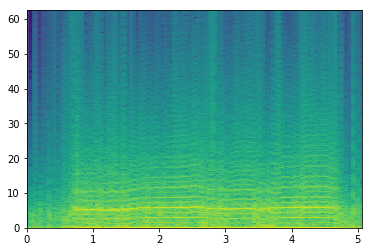

In [69]:
filtered_sig =  BandpassFilter(ppg, (high_pass,low_pass), fs=fs)

specs, freqs, _, _ = plt.specgram(filtered_sig, NFFT= 8*fs, Fs=fs, noverlap= 6*fs, xextent= [0, len(ppg)/fs/60])
specsm, freqsm, _, _ = plt.specgram(acc, NFFT= 8*fs, Fs=fs , noverlap= 6*fs, xextent= [0, len(ppg)/fs/60])

In [71]:
specs_3 = freqs[specs.argsort(axis=0)[-3:]]
specs_3

array([[ 1.125,  2.5  ,  2.625,  2.5  ,  1.   ,  1.   ,  2.5  ,  1.375,
         2.5  ,  2.375,  1.   ,  1.   ,  1.375,  1.   ,  1.25 ,  0.875,
         1.   ,  1.25 ,  1.375,  1.625,  1.125,  2.5  ,  2.375,  3.   ,
         2.5  ,  2.75 ,  2.75 ,  3.25 ,  2.5  ,  2.5  ,  2.5  ,  2.25 ,
         2.5  ,  2.375,  2.375,  2.375,  2.75 ,  2.5  ,  2.5  ,  2.75 ,
         2.5  ,  2.5  ,  2.75 ,  2.75 ,  2.   ,  2.625,  2.875,  2.625,
         2.75 ,  1.375,  2.   ,  1.375,  3.125,  2.875,  2.625,  3.   ,
         2.75 ,  1.5  ,  3.125,  2.125,  1.5  ,  1.375,  1.5  ,  3.   ,
         2.75 ,  1.5  ,  2.75 ,  1.5  ,  1.5  ,  1.5  ,  1.5  ,  1.5  ,
         1.5  ,  1.5  ,  1.5  ,  2.875,  1.5  ,  3.125,  2.625,  2.5  ,
         2.875,  2.5  ,  2.625,  1.75 ,  2.875,  2.5  ,  2.5  ,  2.875,
         2.875,  2.5  ,  2.5  ,  2.5  ,  1.375,  2.875,  2.5  ,  2.875,
         1.375,  2.875,  1.375,  1.375,  3.   ,  1.   ,  2.625,  2.75 ,
         2.   ,  2.625,  2.75 ,  3.   ,  3.   ,  2.875,  2.875, 

In [9]:
# plt.plot((np.arange((148 * fs)/60)/60), y = ground_truth)

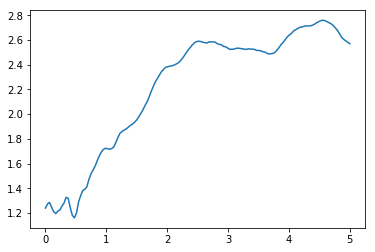

In [10]:
plt.plot(np.linspace(0,5,num=148),sp.io.loadmat(ref_fls[0])['BPM0']/60)

Text(0,0.5,'Frequency (Hz)')

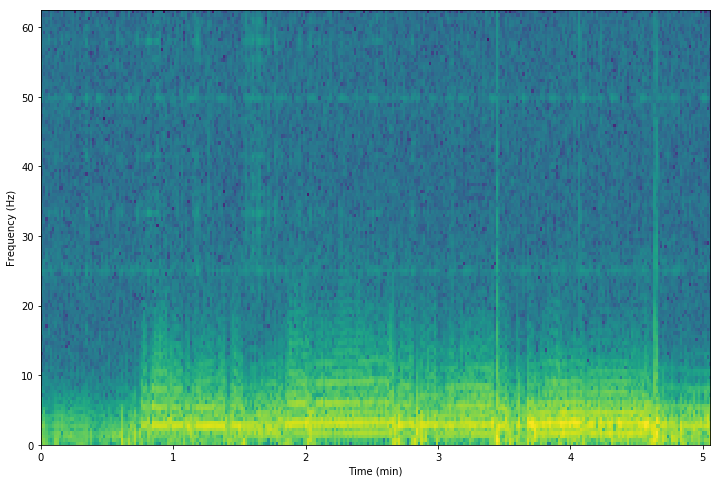

In [12]:
plt.figure(figsize= (12,8))
plt.specgram(ppg, NFFT= 250, Fs=fs, noverlap= 125, xextent= [0, len(ppg)/fs/60])
plt.xlabel('Time (min)')
plt.ylabel('Frequency (Hz)')

Text(0,0.5,'Frequency (Hz)')

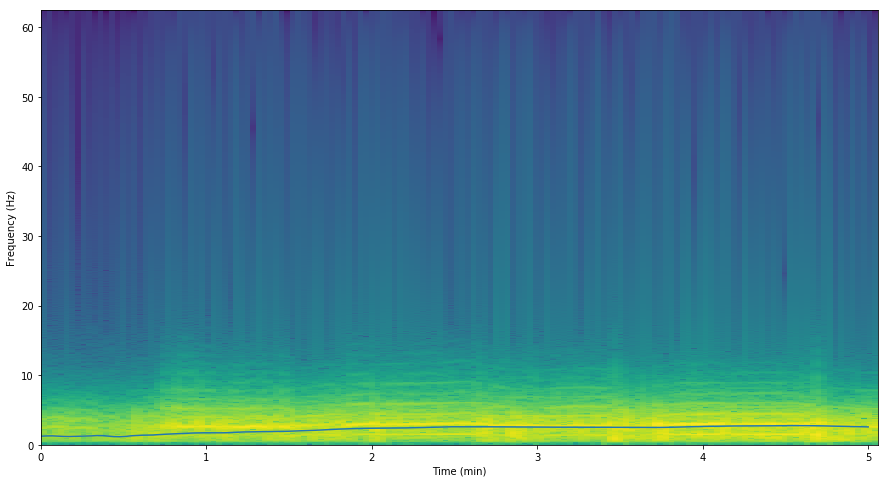

In [13]:
filtered_sig =  BandpassFilter(ppg, (high_pass,low_pass), fs=fs)

plt.figure(figsize= (15,8))
specs, freqs, _, _ = plt.specgram(filtered_sig, NFFT= 8*fs, Fs=fs, noverlap= 6*fs, xextent= [0, len(ppg)/fs/60])
plt.plot(np.linspace(0,5,num=148),sp.io.loadmat(ref_fls[0])['BPM0']/60)
plt.xlabel('Time (min)')
plt.ylabel('Frequency (Hz)')

(501,)
(501, 148)


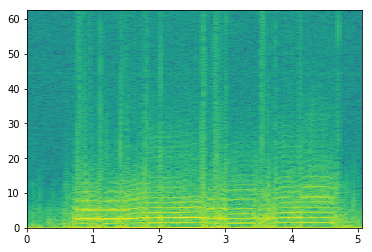

In [14]:
specsz, freqsz, _, _ = plt.specgram(accz, NFFT= 8*fs, Fs=fs , noverlap= 6*fs, xextent= [0, len(ppg)/fs/60])
specsx, freqsx, _, _ = plt.specgram(accx, NFFT= 8*fs, Fs=fs , noverlap= 6*fs, xextent= [0, len(ppg)/fs/60])
specsy, freqsy, _, _ = plt.specgram(accy, NFFT= 8*fs, Fs=fs , noverlap= 6*fs, xextent= [0, len(ppg)/fs/60])
print(freqsz.shape)
print(specsz.shape)

In [133]:
freqs[specs.argsort(0)[-1]]

array([ 1.25 ,  1.25 ,  1.25 ,  1.25 ,  1.125,  1.125,  1.25 ,  1.25 ,
        1.25 ,  1.25 ,  1.375,  1.375,  1.25 ,  1.125,  1.125,  1.25 ,
        1.25 ,  1.125,  1.875,  1.375,  1.25 ,  2.625,  2.75 ,  2.625,
        2.625,  2.625,  2.625,  2.625,  2.625,  2.625,  2.625,  2.625,
        2.625,  2.625,  2.5  ,  2.5  ,  2.625,  2.625,  2.625,  2.625,
        2.625,  2.625,  2.625,  2.5  ,  2.5  ,  2.75 ,  2.75 ,  2.75 ,
        1.375,  2.125,  2.125,  2.125,  2.25 ,  2.625,  2.75 ,  2.875,
        2.875,  2.875,  3.   ,  2.875,  2.875,  2.875,  2.875,  2.875,
        2.875,  2.875,  2.875,  2.875,  3.   ,  3.   ,  3.   ,  3.   ,
        3.   ,  3.   ,  3.   ,  3.   ,  3.   ,  3.   ,  3.   ,  2.625,
        2.75 ,  2.75 ,  2.75 ,  2.75 ,  2.75 ,  2.75 ,  2.75 ,  2.75 ,
        2.75 ,  2.625,  2.625,  2.625,  2.75 ,  2.75 ,  2.875,  2.75 ,
        2.75 ,  2.75 ,  2.75 ,  2.75 ,  2.75 ,  2.375,  2.375,  2.375,
        2.125,  2.5  ,  2.5  ,  2.625,  2.875,  3.   ,  2.5  ,  2.875,
      

In [18]:
freqs[specs.argsort(axis=0)[-2]]

array([ 2.375,  1.375,  1.375,  2.625,  1.25 ,  1.25 ,  1.125,  2.5  ,
        1.125,  1.125,  1.25 ,  1.25 ,  0.875,  1.25 ,  1.   ,  1.125,
        1.125,  1.375,  2.5  ,  1.5  ,  1.375,  2.75 ,  2.625,  2.5  ,
        2.75 ,  2.5  ,  2.5  ,  2.5  ,  2.75 ,  2.75 ,  2.75 ,  2.5  ,
        2.375,  2.5  ,  2.625,  2.625,  2.5  ,  2.75 ,  2.75 ,  2.5  ,
        2.375,  2.75 ,  2.5  ,  2.625,  2.75 ,  2.   ,  2.   ,  2.   ,
        2.   ,  2.875,  2.25 ,  2.25 ,  3.25 ,  2.75 ,  2.875,  2.75 ,
        3.   ,  3.   ,  2.875,  3.   ,  2.75 ,  3.   ,  3.   ,  2.75 ,
        3.   ,  3.   ,  3.   ,  3.   ,  2.875,  2.875,  2.875,  2.875,
        2.875,  3.125,  3.125,  1.5  ,  2.875,  2.875,  2.875,  2.75 ,
        2.625,  2.875,  2.875,  1.625,  2.625,  2.625,  2.875,  2.625,
        2.625,  2.75 ,  2.75 ,  2.75 ,  2.625,  2.625,  2.75 ,  2.625,
        2.625,  1.375,  2.625,  2.875,  2.875,  0.875,  2.5  ,  2.25 ,
        2.5  ,  2.75 ,  2.625,  3.25 ,  2.75 ,  2.625,  2.625,  2.75 ,
      

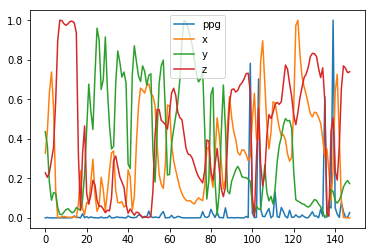

In [134]:
indx = 0
plt.plot(specs[indx]/specs[indx].max(), label = 'ppg')
plt.plot(specsx[indx]/specsx[indx].max(), label = 'x')
plt.plot(specsy[indx]/specsy[indx].max(), label = 'y')
plt.plot(specsz[indx]/specsz[indx].max(), label = 'z')
plt.legend()

In [20]:
specsx[indx].min()

0.0006322767357733488

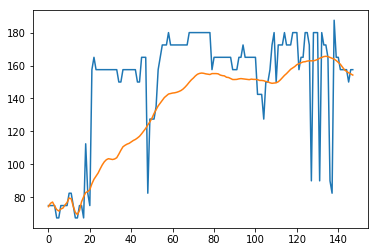

In [136]:
plt.plot(freqs[specs.argmax(axis=0)]*60)
# plt.plot(freqs[specs.argsort(axis=0)[-2]]*60)
plt.plot(ground_truth)

In [137]:
specs_3 = freqs[specs.argsort(axis=0)[-3:]]

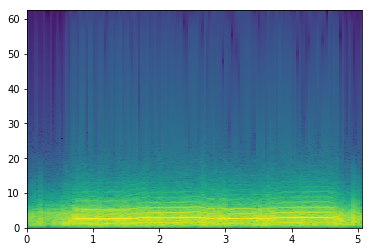

In [138]:
specsm, freqsm, _, _ = plt.specgram(filtered_acc, NFFT= 8*fs, Fs=fs , noverlap= 6*fs, xextent= [0, len(ppg)/fs/60])

In [85]:
specs_acc = freqsm[specsm.argsort(0)[-1]]

In [86]:
specs_3.shape

(3, 148)

In [110]:
specs_3 = freqs[specs.argsort(axis=0)[-3:]]
preds = []
for i in range(specs_3.shape[1]):
    if specs_3[2,i] != specs_acc[i]:
        preds.append(specs_3[0,i])
    elif specs_3[1,i] != specs_acc[i]:
        preds.append(specs_3[1,i])
    else:
        preds.append(specs_3[0,i])
preds = np.array(preds)

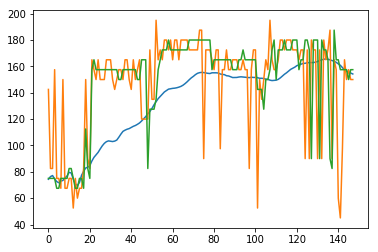

In [118]:
plt.plot(ground_truth)
# plt.plot(preds*60)
plt.plot(specs_3[1]*60)
plt.plot(specs_3[2]*60)
# plt.plot(specs_3[0]*60)


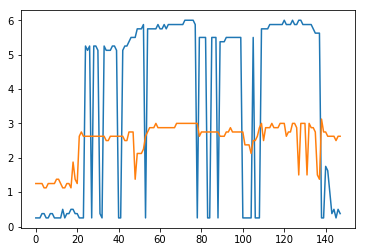

In [106]:
plt.plot(freqsm[specsm.argsort(0)[-3]])
plt.plot(specs_3[2])

In [80]:
preds.shape

(211,)

In [91]:
def featurize(ppg, accx, accy, accz):
    """ Create features """
    ppg = bandpass_filter(ppg)
    accx = bandpass_filter(accx)
    accy = bandpass_filter(accy)
    accz = bandpass_filter(accz)
    
    
    # Fourier Transform and the frequency domain
    fs = 125
    n = len(ppg) * 4
    freqs = np.fft.rfftfreq(n, 1/fs)
    fft = np.abs(np.fft.rfft(ppg,n))
    fft[freqs <= 40/60.0] = 0.0
    fft[freqs >= 240/60.0] = 0.0
    
    # L2-Norms of acc
    l2_acc = np.sqrt(accx**2 + accy**2 + accz**2)
    
    # FFT for acc
    acc_fft = np.abs(np.fft.rfft(l2_acc, n))
    acc_fft[freqs <= 40/60.0] = 0.0
    acc_fft[freqs >= 240/60.0] = 0.0
    
    # max frequency for ppg as a feature
    ppg_feature = freqs[np.argmax(fft)]
    # max frequency for L2 norm of acc
    acc_feature = freqs[np.argmax(acc_fft)]
    
    return (np.array([ppg_feature, acc_feature]), ppg, accx, accy, accz)

-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithhm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

Your write-up goes here...

-----
### Next Steps
You will now go to **Test Your Algorithm** to apply a unit test to confirm that your algorithm met the success criteria. 